In [ ]:
import librosa
import keras
import sys
import numpy as np
from google.colab import drive
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras import Sequential
import scipy.stats
import matplotlib.pyplot as plt
from keras.saving import load_model


# mount drive
drive.mount('/content/drive')
# bearing folder: https://drive.google.com/drive/folders/1QNFjEhD6mJPFXP2rvojsc3-VSEGuqqgn?usp=sharing

# gdown exceeds download limit
# gdown.download_folder(id='1QNFjEhD6mJPFXP2rvojsc3-VSEGuqqgn', quiet=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# bearing audio training path
# dataset = 'bearing'
# data_dir = '/content/drive/MyDrive/bearing/train'

dataset = 'bearing'
dataset_dir = f'/content/drive/MyDrive/{dataset}/'

data_dir = dataset_dir + 'train'
test_data_dir = dataset_dir + 'test'

train_files = []
for file_name in os.listdir(data_dir):
    train_files.append(os.path.join(data_dir, file_name))

print(len(train_files))

1000


In [ ]:
# taken directly from https://github.com/nttcslab/dcase2023_task2_baseline_ae/blob/main/datasets/loader_common.py as the preprocessing step with modifications to the parameters that fit the description
def file_load(wav_name, mono=False):
    """
    load .wav file.

    wav_name : str
        target .wav file
    mono : boolean
        When load a multi channels file and this param True, the returned data will be merged for mono data

    return : numpy.array( float )
    """
    try:
        return librosa.load(wav_name, sr=None, mono=mono)
    except:
        print("file_broken or not exists!! : {}".format(wav_name))

def file_to_vectors(file_name,
                    n_mels=128,
                    n_frames=5,
                    n_fft=1024,
                    hop_length=512,
                    power=2.0,
                    fmax=None,
                    # fmin=None,
                    fmin=0.0,
                    win_length=None):
    """
    convert file_name to a vector array.

    file_name : str
        target .wav file

    return : numpy.array( numpy.array( float ) )
        vector array
        * dataset.shape = (dataset_size, feature_vector_length)
    """

    # calculate the number of dimensions
    dims = n_mels * n_frames

    # generate melspectrogram using librosa
    y, sr = file_load(file_name, mono=True)
    mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                        sr=sr,
                                                        n_fft=n_fft,
                                                        hop_length=hop_length,
                                                        n_mels=n_mels,
                                                        power=power,
                                                        fmax=fmax,
                                                        fmin=fmin,
                                                        win_length=win_length)


    # convert melspectrogram to log mel energies
    log_mel_spectrogram = 20.0 / power * np.log10(np.maximum(mel_spectrogram, sys.float_info.epsilon))

    # calculate total vector size
    n_vectors = len(log_mel_spectrogram[0, :]) - n_frames + 1

    # skip too short clips
    if n_vectors < 1:
        return np.empty((0, dims))

    # generate feature vectors by concatenating multi frames
    vectors = np.zeros((n_vectors, dims))
    for t in range(n_frames):
        vectors[:, n_mels * t : n_mels * (t + 1)] = log_mel_spectrogram[:, t : t + n_vectors].T

    return vectors



In [ ]:
dims = 128 * 5
idx = 0
n_hop_frames = 1

msg = 'generating training dataset'
for idx in tqdm(range(len(train_files)), desc=msg):
    vectors = file_to_vectors(train_files[idx])
    vectors = vectors[: : n_hop_frames, :]
    if idx == 0:
        data = np.zeros((len(train_files) * vectors.shape[0], dims), float)
    if len(train_files) * vectors.shape[0] > data.shape[0]:
        tmp_data = np.zeros((len(train_files) * vectors.shape[0], dims), float)
        tmp_data[:data.shape[0], :] = data
        data = tmp_data
    data[vectors.shape[0] * idx : vectors.shape[0] * (idx + 1), :] = vectors

print(data.shape)

generating training dataset: 100%|██████████| 1000/1000 [01:41<00:00,  9.86it/s]

(309000, 640)


In [ ]:
def get_baseline_fc_model(input_dims):
    model = Sequential()
    # encoder start
    # Number of Hidden Layers: 4
    model.add(keras.layers.Dense(128, input_shape=(input_dims,)))
    model.add(keras.layers.BatchNormalization(momentum=0.01))
    model.add(keras.layers.Activation('relu'))

    model.add(keras.layers.Dense(128))
    model.add(keras.layers.BatchNormalization(momentum=0.01))
    model.add(keras.layers.Activation('relu'))

    model.add(keras.layers.Dense(128))
    model.add(keras.layers.BatchNormalization(momentum=0.01))
    model.add(keras.layers.Activation('relu'))

    model.add(keras.layers.Dense(128))
    model.add(keras.layers.BatchNormalization(momentum=0.01))
    model.add(keras.layers.Activation('relu'))

    model.add(keras.layers.Dense(8))
    model.add(keras.layers.BatchNormalization(momentum=0.01))
    model.add(keras.layers.Activation('relu'))
    # encoder end

    # decoder start
    # Number of Hidden Layers: 4
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.BatchNormalization(momentum=0.01))
    model.add(keras.layers.Activation('relu'))

    model.add(keras.layers.Dense(128))
    model.add(keras.layers.BatchNormalization(momentum=0.01))
    model.add(keras.layers.Activation('relu'))

    model.add(keras.layers.Dense(128))
    model.add(keras.layers.BatchNormalization(momentum=0.01))
    model.add(keras.layers.Activation('relu'))

    model.add(keras.layers.Dense(128))
    model.add(keras.layers.BatchNormalization(momentum=0.01))
    model.add(keras.layers.Activation('relu'))

    model.add(keras.layers.Dense(input_dims))
    # decoder end

    return model


model = get_baseline_fc_model(dims)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │           1,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 269,992 (1.03 MB)

 Trainable params: 267,928 (1.02 MB)

 Non-trainable params: 2,064 (8.06 KB)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

x_train, x_test, _, _ = train_test_split(data, data, test_size=0.1, random_state=42)
print(x_train.shape)
print(x_test.shape)

(278100, 640)
(30900, 640)


In [ ]:
# history = model.fit(x_train, x_train, epochs=100, batch_size=256, shuffle=True, validation_data=(x_test, x_test))
# model.save(dataset_dir + 'bearing_baseline.keras')

In [ ]:
# Predict the reconstructed data
model = keras.models.load_model(dataset_dir + 'bearing_baseline.keras')
predicted_data = model.predict(x_train)  # batch size 32

# Calculate the mse between the original data and the prediction
reconstruction_error = np.mean(np.square(x_train - predicted_data), axis=1)
print(reconstruction_error.shape)

8691/8691 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step
(278100,)


In [ ]:
# Fit a gamma distribution to the reconstruction errors
shape_hat, loc_hat, scale_hat = scipy.stats.gamma.fit(reconstruction_error)

In [ ]:
# from config.yaml in baseline model
dt = 0.9

decision_threshold = scipy.stats.gamma.ppf(q=dt, a=shape_hat, loc=loc_hat, scale=scale_hat)
print(np.median(reconstruction_error))
q_1, q_3 = np.percentile(reconstruction_error, [25, 75])
print(q_3 + 1.5 * (q_3 - q_1))  # 9.43479

print(decision_threshold)

9.490411060344725
13.124403481884992
11.608530191242423


In [ ]:
def plot_histogram(reconstruction_error, decision_threshold):
    plt.figure(figsize=(10, 6))
    _, bins, _ = plt.hist(reconstruction_error, bins=100, edgecolor='black')
    plt.xlim([5, 30])
    plt.xlabel('Mean Squared Error')
    plt.ylabel('Frequency')
    plt.title('Histogram of Training Reconstruction Errors')
    plt.axvline(x=decision_threshold, color='r', linestyle='--', label=f'Anomaly Decision Threshold: {np.round(decision_threshold, 3)}')
    plt.legend(loc='upper right')
    plt.show()

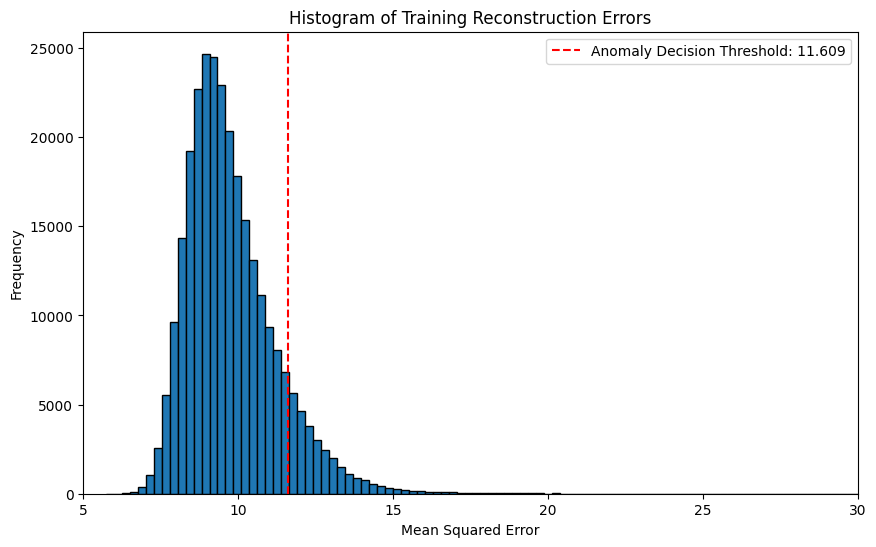

In [ ]:
plot_histogram(reconstruction_error, decision_threshold)

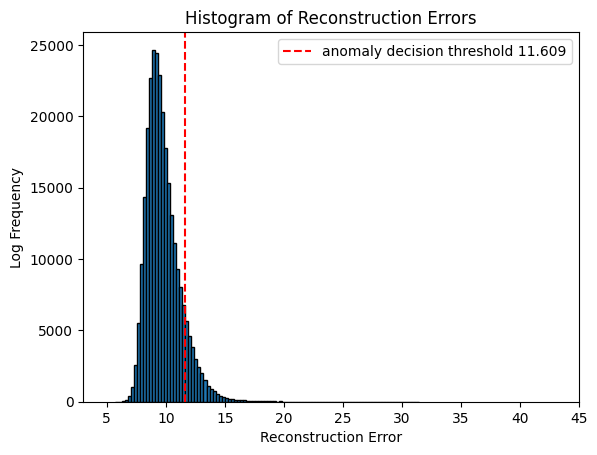

In [ ]:
# bins = np.geomspace(1, decision_threshold + 100, 80)

_, bins, _ = plt.hist(reconstruction_error, bins=100, log=False, edgecolor='black')
plt.xlabel('Reconstruction Error')
# plt.xscale('log')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors')
plt.xlim([3, 45])
plt.axvline(x=decision_threshold, color='r', linestyle='--', label=f'anomaly decision threshold {np.round(decision_threshold, 3)}')
plt.legend(loc='upper right')
plt.show()

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
# prompt: generate a matplotlib graph of keras model training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylim([0, 30])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, np.max(history.history['loss'])])
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
#model = keras.models.load_model(dataset_dir + 'bearing_baseline.keras')

In [ ]:
dims = 128 * 5
idx = 0
n_hop_frames = 1

test_files = []
for file_name in os.listdir(test_data_dir):
    test_files.append(os.path.join(test_data_dir, file_name))

print(len(test_files))

msg = 'generating testing dataset'
test_files_label = []
normal = [0]
anomaly = [1]
for idx in tqdm(range(len(test_files)), desc=msg):
    current_file_name = test_files[idx]
    if 'normal' in current_file_name:
        test_files_label += normal
    else:
        test_files_label += anomaly
    vectors = file_to_vectors(current_file_name)
    vectors = vectors[: : n_hop_frames, :]
    if idx == 0:
        test_data = np.zeros((len(test_files) * vectors.shape[0], dims), float)
    if len(test_files) * vectors.shape[0] > test_data.shape[0]:
        tmp_data = np.zeros((len(train_files) * vectors.shape[0], dims), float)
        tmp_data[:test_data.shape[0], :] = test_data
        test_data = tmp_data
    test_data[vectors.shape[0] * idx : vectors.shape[0] * (idx + 1), :] = vectors

print(test_data.shape)
print(len(test_files_label))
print(test_files_label)

200


generating testing dataset: 100%|██████████| 200/200 [00:21<00:00,  9.17it/s]

(61800, 640)
200
[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0]


In [ ]:
test_idc = 1
print(test_files_label[-1])
print(test_files[-1])

0
/content/drive/MyDrive/bearing/test/section_00_target_test_normal_0001_pro_A_vel_4_loc_E.wav


In [ ]:
import numpy as np

anomaly_score_list = []
decision_result_list = []
audio_names_to_show = []
audio_indexes_to_show = []

for file_path in tqdm(test_files, desc='evaluating test set'):
    try:
        data = file_to_vectors(file_path, n_mels=128, n_frames=5, n_fft=1024, hop_length=512, power=2.0)
        reconstruction = model.predict(data, verbose=0)
        mse = np.mean(np.square(data - reconstruction))
        if mse >= decision_threshold * 1.5:
            audio_names_to_show.append(file_path)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        continue

    anomaly_score_list.append(mse)

    is_anomaly = 1 if mse > decision_threshold else 0
    decision_result_list.append(is_anomaly)


evaluating test set:   4%|▍         | 9/200 [00:00<00:04, 43.43it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0023_pro_A_vel_12_loc_G.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0049_pro_B_vel_16_loc_H.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0045_pro_B_vel_8_loc_C.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0006_pro_A_vel_4_loc_B.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0037_pro_B_vel_8_loc_A.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0004_pro_A_vel_4_loc_A.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0035_pro_B_vel_16_loc_B.wav: name 'model'

evaluating test set:   7%|▋         | 14/200 [00:00<00:04, 41.02it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0009_pro_A_vel_4_loc_C.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0028_pro_B_vel_8_loc_A.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0020_pro_A_vel_4_loc_D.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0032_pro_B_vel_8_loc_B.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0002_pro_A_vel_4_loc_E.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0010_pro_A_vel_12_loc_C.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0045_pro_B_vel_8_loc_D.wav: name 'model' is n

evaluating test set:  12%|█▏        | 23/200 [00:00<00:04, 37.96it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0014_pro_A_vel_4_loc_E.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0046_pro_B_vel_16_loc_C.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0012_pro_A_vel_12_loc_F.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0040_pro_B_vel_8_loc_C.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0005_pro_A_vel_12_loc_E.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0026_pro_B_vel_8_loc_A.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0030_pro_B_vel_16_loc_B.wav: name 'model'

evaluating test set:  16%|█▌        | 31/200 [00:00<00:05, 33.74it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0031_pro_B_vel_16_loc_E.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0009_pro_A_vel_4_loc_F.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0043_pro_B_vel_16_loc_B.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0007_pro_A_vel_4_loc_G.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0021_pro_A_vel_4_loc_D.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0034_pro_B_vel_8_loc_F.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0006_pro_A_vel_12_loc_A.wav: name 'model' is

evaluating test set:  18%|█▊        | 35/200 [00:01<00:05, 29.83it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0027_pro_B_vel_16_loc_A.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0023_pro_A_vel_12_loc_D.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0018_pro_A_vel_12_loc_G.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0024_pro_A_vel_12_loc_H.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0005_pro_A_vel_12_loc_A.wav: name 'model' is not defined


evaluating test set:  20%|█▉        | 39/200 [00:01<00:06, 24.50it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0050_pro_B_vel_16_loc_D.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0026_pro_B_vel_8_loc_A.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0013_pro_A_vel_12_loc_H.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0001_pro_A_vel_4_loc_A.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0002_pro_A_vel_4_loc_A.wav: name 'model' is not defined


evaluating test set:  22%|██▎       | 45/200 [00:01<00:07, 21.76it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0042_pro_B_vel_16_loc_G.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0020_pro_A_vel_4_loc_H.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0035_pro_B_vel_16_loc_F.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0035_pro_B_vel_16_loc_D.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0027_pro_B_vel_8_loc_A.wav: name 'model' is not defined


evaluating test set:  24%|██▍       | 48/200 [00:01<00:06, 21.82it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0016_pro_A_vel_4_loc_E.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0003_pro_A_vel_4_loc_E.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0022_pro_A_vel_4_loc_H.wav: name 'model' is not defined


evaluating test set:  28%|██▊       | 55/200 [00:02<00:06, 23.28it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0036_pro_B_vel_16_loc_H.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0039_pro_B_vel_16_loc_A.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0025_pro_A_vel_12_loc_H.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0022_pro_A_vel_4_loc_D.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0031_pro_B_vel_16_loc_A.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0040_pro_B_vel_8_loc_G.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0037_pro_B_vel_16_loc_F.wav: name 'model' 

evaluating test set:  32%|███▏      | 63/200 [00:02<00:04, 29.01it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0015_pro_A_vel_4_loc_E.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0007_pro_A_vel_12_loc_B.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0011_pro_A_vel_12_loc_B.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0016_pro_A_vel_4_loc_G.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0017_pro_A_vel_12_loc_E.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0010_pro_A_vel_4_loc_F.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0008_pro_A_vel_12_loc_B.wav: name 'model'

evaluating test set:  36%|███▌      | 71/200 [00:02<00:03, 32.95it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0035_pro_B_vel_16_loc_H.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0029_pro_B_vel_16_loc_F.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0024_pro_A_vel_12_loc_D.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0024_pro_A_vel_4_loc_H.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0044_pro_B_vel_8_loc_C.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0011_pro_A_vel_12_loc_H.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0050_pro_B_vel_16_loc_H.wav: name 'mod

evaluating test set:  40%|███▉      | 79/200 [00:02<00:03, 33.97it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0049_pro_B_vel_16_loc_H.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0045_pro_B_vel_8_loc_H.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0006_pro_A_vel_12_loc_F.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0013_pro_A_vel_12_loc_B.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0045_pro_B_vel_8_loc_G.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0048_pro_B_vel_16_loc_D.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0018_pro_A_vel_12_loc_E.wav: name 'model'

evaluating test set:  44%|████▎     | 87/200 [00:02<00:03, 34.78it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0008_pro_A_vel_4_loc_F.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0021_pro_A_vel_12_loc_C.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0046_pro_B_vel_8_loc_D.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0025_pro_A_vel_4_loc_H.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0041_pro_B_vel_8_loc_B.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0028_pro_B_vel_8_loc_E.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0012_pro_A_vel_12_loc_D.wav: name 'model' i

evaluating test set:  48%|████▊     | 95/200 [00:03<00:02, 35.28it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0023_pro_A_vel_4_loc_D.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0019_pro_A_vel_4_loc_F.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0044_pro_B_vel_8_loc_D.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0026_pro_B_vel_8_loc_E.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0014_pro_A_vel_4_loc_G.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0032_pro_B_vel_16_loc_G.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0008_pro_A_vel_4_loc_G.wav: name 'model' i

evaluating test set:  52%|█████▏    | 103/200 [00:03<00:02, 34.99it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0048_pro_B_vel_8_loc_H.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0010_pro_A_vel_4_loc_B.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0038_pro_B_vel_8_loc_A.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0027_pro_B_vel_16_loc_E.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0015_pro_A_vel_4_loc_G.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0032_pro_B_vel_16_loc_C.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0023_pro_A_vel_12_loc_H.wav: name 'model' 

evaluating test set:  56%|█████▌    | 111/200 [00:03<00:02, 35.83it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0040_pro_B_vel_16_loc_A.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0015_pro_A_vel_4_loc_A.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0001_pro_A_vel_4_loc_A.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0039_pro_B_vel_8_loc_G.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0033_pro_B_vel_8_loc_H.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0050_pro_B_vel_16_loc_H.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0021_pro_A_vel_4_loc_G.wav: name 'model' 

evaluating test set:  60%|█████▉    | 119/200 [00:03<00:02, 36.71it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0043_pro_B_vel_16_loc_F.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0032_pro_B_vel_8_loc_F.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0041_pro_B_vel_16_loc_C.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0025_pro_A_vel_12_loc_D.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0031_pro_B_vel_8_loc_C.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0041_pro_B_vel_8_loc_F.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0022_pro_A_vel_12_loc_G.wav: name 'model

evaluating test set:  62%|██████▏   | 123/200 [00:03<00:02, 33.64it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0038_pro_B_vel_8_loc_C.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0041_pro_B_vel_16_loc_G.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0046_pro_B_vel_8_loc_G.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0021_pro_A_vel_4_loc_H.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0043_pro_B_vel_16_loc_C.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0049_pro_B_vel_16_loc_D.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0005_pro_A_vel_12_loc_A.wav: name 'model' is

evaluating test set:  68%|██████▊   | 136/200 [00:04<00:01, 48.31it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0047_pro_B_vel_16_loc_H.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0033_pro_B_vel_16_loc_C.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0036_pro_B_vel_16_loc_D.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0033_pro_B_vel_8_loc_F.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0040_pro_B_vel_16_loc_E.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0044_pro_B_vel_16_loc_F.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0036_pro_B_vel_16_loc_F.wav: name 'mode

evaluating test set:  75%|███████▌  | 150/200 [00:04<00:00, 58.07it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0019_pro_A_vel_4_loc_C.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0022_pro_A_vel_12_loc_C.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0024_pro_A_vel_4_loc_D.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0013_pro_A_vel_12_loc_F.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0019_pro_A_vel_12_loc_C.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0028_pro_B_vel_8_loc_B.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0012_pro_A_vel_12_loc_H.wav: name 'model

evaluating test set:  82%|████████▏ | 164/200 [00:04<00:00, 61.45it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0046_pro_B_vel_8_loc_H.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0030_pro_B_vel_16_loc_A.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0047_pro_B_vel_8_loc_D.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0002_pro_A_vel_12_loc_E.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0028_pro_B_vel_8_loc_F.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0037_pro_B_vel_16_loc_B.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0034_pro_B_vel_8_loc_D.wav: name 'model' 

evaluating test set:  88%|████████▊ | 177/200 [00:04<00:00, 52.40it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0029_pro_B_vel_16_loc_A.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0031_pro_B_vel_16_loc_G.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0016_pro_A_vel_4_loc_C.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0007_pro_A_vel_12_loc_E.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0049_pro_B_vel_16_loc_D.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0011_pro_A_vel_12_loc_F.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0004_pro_A_vel_12_loc_A.wav: name 'model

evaluating test set:  95%|█████████▌| 190/200 [00:05<00:00, 56.53it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0019_pro_A_vel_12_loc_G.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0029_pro_B_vel_16_loc_E.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0005_pro_A_vel_12_loc_F.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0017_pro_A_vel_12_loc_G.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0033_pro_B_vel_8_loc_B.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_anomaly_0037_pro_B_vel_8_loc_E.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0006_pro_A_vel_12_loc_E.wav: name 'model' 

evaluating test set: 100%|██████████| 200/200 [00:05<00:00, 38.31it/s]

Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0014_pro_A_vel_4_loc_C.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0042_pro_B_vel_16_loc_C.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_target_test_normal_0027_pro_B_vel_8_loc_E.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0003_pro_A_vel_12_loc_A.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0018_pro_A_vel_12_loc_B.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0017_pro_A_vel_12_loc_C.wav: name 'model' is not defined
Error processing file /content/drive/MyDrive/bearing/test/section_00_source_test_normal_0018_pro_A_vel_12_loc_C.wav: name 'model' 

In [ ]:
from sklearn.metrics import classification_report
from keras.metrics import AUC
from sklearn.metrics import roc_auc_score

print('Bearing report: \nAUC: ', roc_auc_score(test_files_label, decision_result_list))
print(classification_report(test_files_label, decision_result_list, target_names=['normal', 'anomaly']))

Bearing report: 
AUC:  0.5499999999999999
              precision    recall  f1-score   support

      normal       0.53      0.89      0.66       100
     anomaly       0.66      0.21      0.32       100

    accuracy                           0.55       200
   macro avg       0.59      0.55      0.49       200
weighted avg       0.59      0.55      0.49       200



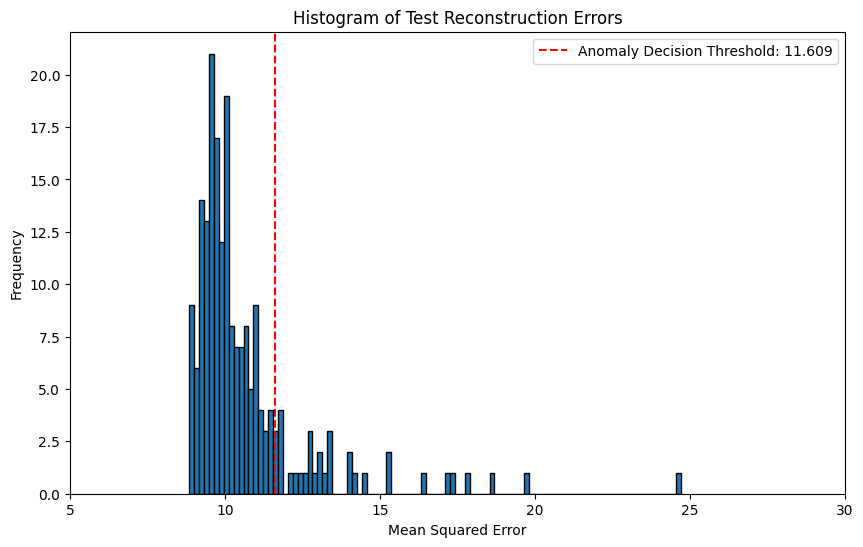

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram of anomaly scores
plt.figure(figsize=(10, 6))
plt.hist(anomaly_score_list, bins=100, edgecolor='black')
plt.axvline(x=decision_threshold, color='r', linestyle='--', label=f'Anomaly Decision Threshold: {decision_threshold:.3f}')
plt.title('Histogram of Test Reconstruction Errors')
plt.xlim([5, 30])
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
def plot_data(original, reconstructed, title, x_lim=[0, 128]):
    x_min = x_lim[0]
    x_max = x_lim[1]
    plt.figure(figsize=(10, 6))
    plt.plot(original, 'b', label='Input')
    plt.plot(reconstructed, 'r', label='Reconstruction')
    plt.fill_between(np.arange(len(original)), reconstructed, original, color='lightcoral', alpha=0.5)
    plt.title(title)
    # plt.ylim(-12, -35)
    plt.xlim(x_min, x_max)
    plt.legend()
    plt.show()

In [ ]:
from IPython.display import Audio

# Large Reconstruction Error
print(len(audio_names_to_show))

audio_name = audio_names_to_show[0]
print(audio_name)
Audio(audio_name, rate=16000)

0


IndexError: list index out of range

In [ ]:

audio_name = audio_names_to_show[1]
print(audio_name)
Audio(audio_name, rate=16000)

/content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0043_pro_B_vel_16_loc_B.wav


In [ ]:
min_idx = np.argmin(anomaly_score_list)
print(anomaly_score_list[min_idx])
audio_name = test_files[min_idx]
print(audio_name)
Audio(audio_name, rate=16000)

8.852966380953626
/content/drive/MyDrive/bearing/test/section_00_source_test_anomaly_0014_pro_A_vel_4_loc_A.wav


In [ ]:
max_idx = np.argmax(anomaly_score_list)
print(anomaly_score_list[max_idx])
audio_name = test_files[max_idx]
print(audio_name)
Audio(audio_name, rate=16000)

8.852966380953626
(1, 640)
(1, 640)


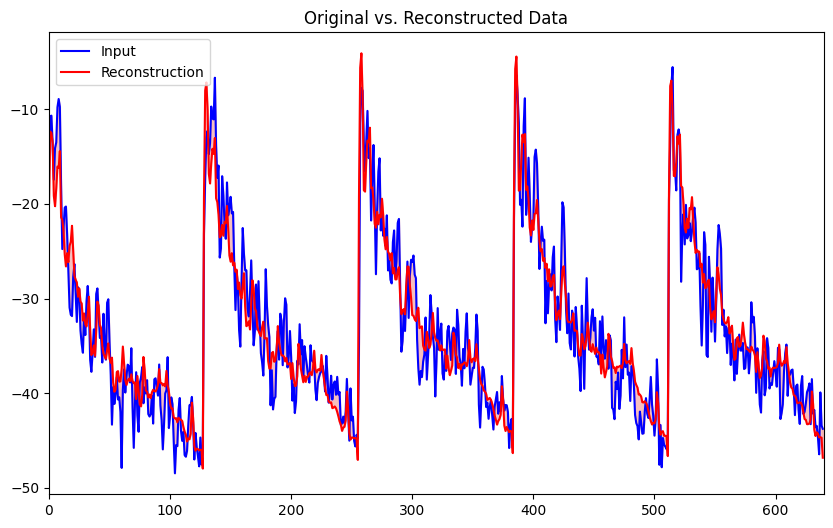

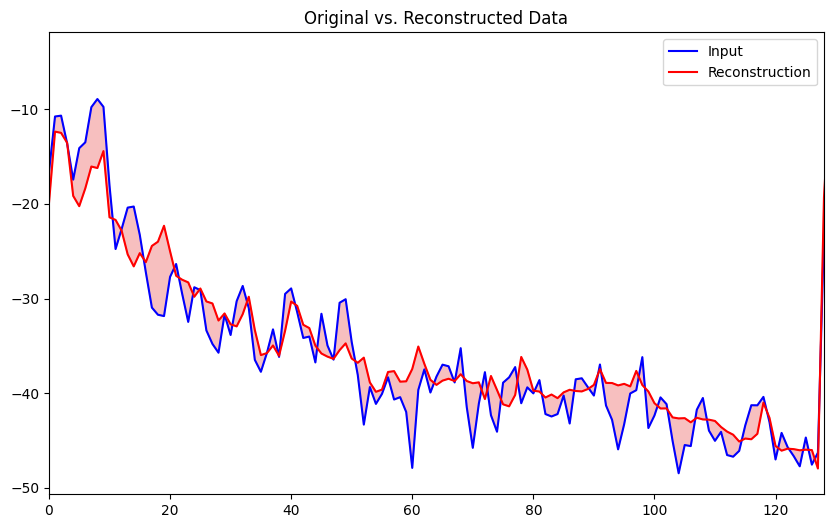

In [ ]:
min_idx = np.argmin(anomaly_score_list)
print(anomaly_score_list[min_idx])
audio_name = test_files[min_idx]
x_temp = file_to_vectors(audio_name, n_mels=128, n_frames=5, n_fft=1024, hop_length=512, power=2.0)

x_temp_reshaped = np.expand_dims(x_temp[0], axis=0)
print(x_temp_reshaped.shape)
reconstruction_temp = model.predict(x_temp_reshaped, verbose=0)
print(reconstruction_temp.shape)
plot_data(x_temp[0], reconstruction_temp[0], 'Original vs. Reconstructed Data', x_lim=[0, 640])
plot_data(x_temp[0], reconstruction_temp[0], 'Original vs. Reconstructed Data', x_lim=[0, 128])

24.719473697680478
(1, 640)
(1, 640)


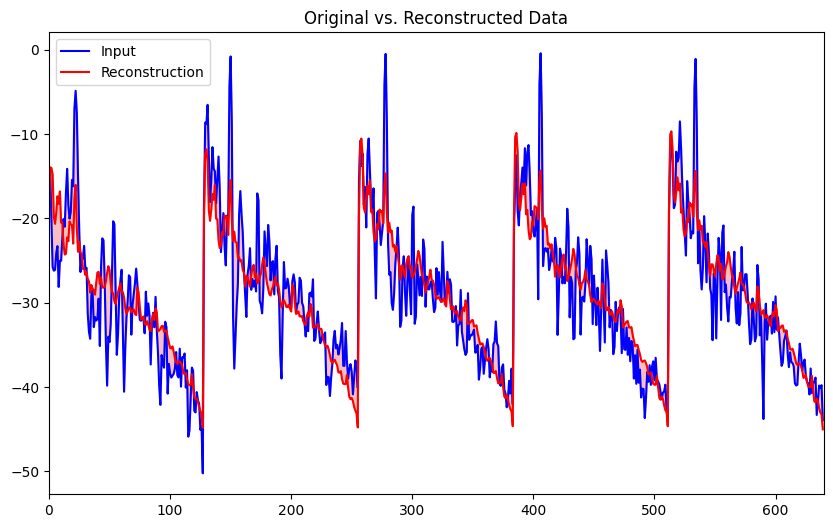

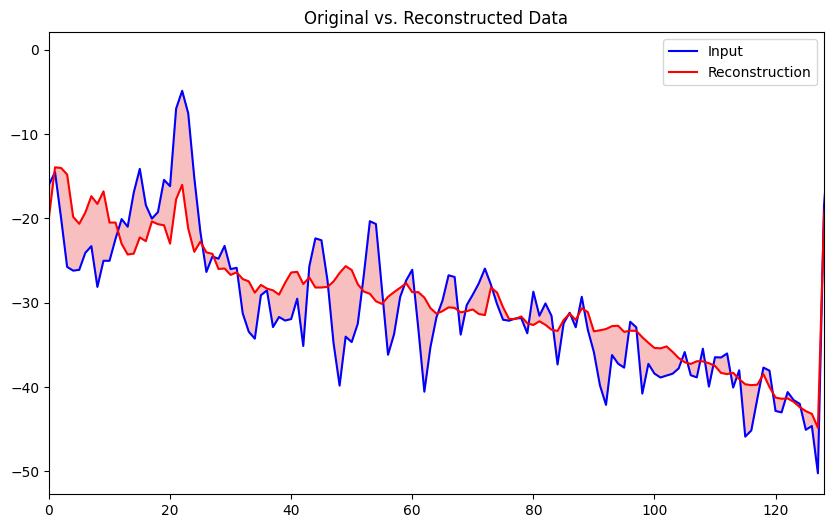

In [ ]:
max_idx = np.argmax(anomaly_score_list)
print(anomaly_score_list[max_idx])
audio_name = test_files[max_idx]
x_temp = file_to_vectors(audio_name, n_mels=128, n_frames=5, n_fft=1024, hop_length=512, power=2.0)

x_temp_reshaped = np.expand_dims(x_temp[0], axis=0)
print(x_temp_reshaped.shape)
reconstruction_temp = model.predict(x_temp_reshaped, verbose=0)
print(reconstruction_temp.shape)
plot_data(x_temp[0], reconstruction_temp[0], 'Original vs. Reconstructed Data', x_lim=[0, 640])
plot_data(x_temp[0], reconstruction_temp[0], 'Original vs. Reconstructed Data', x_lim=[0, 128])